# Setup

In [1]:
# Library imports
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from google.colab import files
import json
import shutil
import matplotlib.pyplot as plt
import zipfile

In [2]:
def clear_annotations_folder(folder_path):
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
      if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)
      elif os.path.isdir(file_path):
        shutil.rmtree(file_path)
    except Exception as e:
      print('Failed to delete %s. Reason: %s' % (file_path, e))

In [3]:
def unzip_and_merge(zip_file_path, destination_folder):
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall("temp_unzip_dir")  # Extract to a temporary directory

    unzipped_dir = "temp_unzip_dir"
    for root, _, files in os.walk(unzipped_dir):
        for file in files:
            source_path = os.path.join(root, file)
            destination_path = os.path.join(destination_folder, file)

            # Check for existing files with the same name
            if os.path.exists(destination_path):
                base, ext = os.path.splitext(file)
                i = 1
                new_file = f"{base}_{i}{ext}"
                destination_path = os.path.join(destination_folder, new_file)
                while os.path.exists(destination_path):
                    i += 1
                    new_file = f"{base}_{i}{ext}"
                    destination_path = os.path.join(destination_folder, new_file)


            shutil.move(source_path, destination_path)

    #Clean up the temporary directory
    shutil.rmtree("temp_unzip_dir")

  except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
  except zipfile.BadZipFile:
    print(f"Error: Invalid zip file at {zip_file_path}")
  except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [4]:
# Create directories
os.makedirs('train_frames', exist_ok=True)
os.makedirs('annotations', exist_ok=True)

In [5]:
# Upload training frames zip'
clear_annotations_folder('train_frames')
uploaded = files.upload()

Saving train_frames.zip to train_frames.zip


In [6]:
unzip_and_merge('train_frames.zip','train_frames')

In [7]:
# Upload jsonl files
clear_annotations_folder('annotations')
uploaded = files.upload(target_dir='annotations')

Saving video4.jsonl to annotations/video4.jsonl
Saving video1.jsonl to annotations/video1.jsonl
Saving video3.jsonl to annotations/video3.jsonl
Saving video2.jsonl to annotations/video2.jsonl


# Dataframe

In [8]:
df_train = pd.DataFrame()

for filename in os.listdir('annotations'):
    if filename.endswith('.jsonl'):
        filepath = os.path.join('annotations', filename)
        with open(filepath, 'r') as f:
            for line in f:
                data = json.loads(line)
                df_train = pd.concat([df_train, pd.DataFrame([data])], ignore_index=True)
df_train.set_index('image', inplace=True)
df_train.head(5)

,labels,timestamp
image,,
2024-09-14_20_08_07.jpeg,[IN HOUSE (S)],1726358887
2024-09-14_20_08_08.jpeg,[IN HOUSE (S)],1726358888
2024-09-14_20_08_09.jpeg,[IN HOUSE (S)],1726358889
2024-09-14_20_08_10.jpeg,[],1726358890
2024-09-14_20_08_11.jpeg,[IN HOUSE (S)],1726358891


In [9]:
# Get unique labels
labels = []
for i in df_train['labels']:
  for j in i:
    if j not in labels:
      labels.append(j)

labels.sort()
labels

['IN FOOD HOPPER',
 'IN HOUSE (N)',
 'IN HOUSE (S)',
 'ON HOUSE (N)',
 'ON HOUSE (S)']

In [10]:
# Create a new DataFrame with columns for each label
df_labels = pd.DataFrame(index=df_train.index)
# Access the index of df_train (which is the 'image' column) and assign it to a new 'image' column in df_labels
df_labels['image'] = df_train.index
# Iterate through the labels and create columns
for label in labels:
    df_labels[label] = 0  # Initialize all label columns with 0

# Fill the label columns based on the 'labels' column in the original DataFrame
for index, row in df_train.iterrows():
    for label in row['labels']:
        df_labels.loc[index, label] = 1

# Set index to image name
df_labels.set_index('image', inplace=True)
df_labels.head(5)

,IN FOOD HOPPER,IN HOUSE (N),IN HOUSE (S),ON HOUSE (N),ON HOUSE (S)
image,,,,,
2024-09-14_20_08_07.jpeg,0,0,1,0,0
2024-09-14_20_08_08.jpeg,0,0,1,0,0
2024-09-14_20_08_09.jpeg,0,0,1,0,0
2024-09-14_20_08_10.jpeg,0,0,0,0,0
2024-09-14_20_08_11.jpeg,0,0,1,0,0


In [11]:
def get_stats(df):
  df_stats = pd.DataFrame(df.sum(axis=0)).rename(columns={0: 'total'}).sort_values(by="total", ascending=False)
  df_stats['percentage'] = 100 * round(df_stats['total'] / len(df), 3)
  labels = df_stats.index.to_list()
  return df_stats

# Get data spread
get_stats(df_labels)

,total,percentage
IN HOUSE (S),706,60.7
IN HOUSE (N),332,28.5
ON HOUSE (N),314,27.0
ON HOUSE (S),153,13.1
IN FOOD HOPPER,71,6.1


In [12]:
df_labels = df_labels.sort_index(ascending=True)
df_labels.head(5)

,IN FOOD HOPPER,IN HOUSE (N),IN HOUSE (S),ON HOUSE (N),ON HOUSE (S)
image,,,,,
2024-06-24_12_11_08.jpeg,0,0,0,0,0
2024-06-24_12_11_09.jpeg,0,0,0,0,0
2024-06-24_12_11_10.jpeg,0,0,0,0,0
2024-06-24_12_11_11.jpeg,0,0,0,0,0
2024-06-24_12_11_12.jpeg,0,1,0,0,0


# Custom Dataset Class

In [13]:
class getDataset(Dataset):
    # Custom dataset class for loading images and labels.
    def __init__(self, df_labels, image_dir, transform=None):
        # Initializes the dataset.
        self.transform = transform
        self.image_dir = image_dir
        self.df_labels = df_labels
        # Get image names from df_labels index
        self.image_names = df_labels.index.tolist()
        # Get the number of classes
        self.num_classes = len(df_labels.columns)

    def __len__(self):
        # Returns the number of samples in the dataset.
        return len(self.image_names)

    def __getitem__(self, idx):
      image_name = self.image_names[idx]
      image_path = os.path.join(self.image_dir, image_name)
      image = Image.open(image_path).convert('RGB')
      if self.transform:
          image = self.transform(image)

      # Safe and consistent label extraction
      label = torch.tensor(self.df_labels.loc[image_name, self.target_label], dtype=torch.float32)

      return image, label

In [14]:
class SingleLabelDataset(Dataset):
    # Custom dataset class for loading images and labels for a single target label.
    def __init__(self, df_labels, image_dir, target_label, transform=None, indices=None):
        # Initializes the dataset.
        self.df_labels = df_labels
        self.image_dir = image_dir
        self.target_label = target_label
        self.transform = transform

        self.image_names = df_labels.index.tolist()
        if indices is not None:
            self.image_names = [self.image_names[i] for i in indices]

    def __len__(self):
        # Returns the number of samples in the dataset.
        return len(self.image_names)

    def __getitem__(self, idx):
        # Loads and returns a sample from the dataset at the given index.
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')  # Open image and convert to RGB
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.df_labels.loc[image_name][self.target_label], dtype=torch.float32)
        return image, label

# Models

In [15]:
class ResNetBinary(nn.Module):
    def __init__(self):
        super(ResNetBinary, self).__init__()

        # Load ResNet18 backbone without pretrained weights
        self.base = models.resnet18(weights=None)

        # self.base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Freeze all parameters (for transfer learning)
        for param in self.base.parameters():
            param.requires_grad = False

        # Replace the classification head
        in_features = self.base.fc.in_features
        self.base.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.base(x).squeeze(1)  # Output shape: [batch_size]

# Evaluation Function

In [16]:
def plot_cv_results(cv_results):
    # Plots the cross-validation results for each label.

    # Extract labels, F1 scores, and accuracies from the cv_results dictionary
    labels = list(cv_results.keys())
    f1_scores = [cv_results[label]['F1'] for label in labels]
    accuracies = [cv_results[label]['Accuracy'] for label in labels]

    # Create an array for the x-axis (label positions)
    x = np.arange(len(labels))
    # Set the width of the bars in the plot
    bar_width = 0.35

    # Create a figure and axes for the plot
    plt.figure(figsize=(12, 6))  # Set the figure size
    # Plot F1 scores as bars
    plt.bar(x - bar_width/2, f1_scores, width=bar_width, label='F1 Score')
    # Plot accuracies as bars next to F1 scores
    plt.bar(x + bar_width/2, accuracies, width=bar_width, label='Accuracy')

    # Set x-axis ticks and labels, rotating them for better readability
    plt.xticks(x, labels, rotation=45, ha='right')
    # Set y-axis label
    plt.ylabel('Score')
    # Set plot title
    plt.title('Cross-Validation Performance per Label')
    # Set y-axis limits
    plt.ylim(0, 1.0)
    # Display legend
    plt.legend()
    # Adjust layout for better spacing
    plt.tight_layout()
    # Show the plot
    plt.show()

In [17]:
def evaluate(model, data_loader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        # Iterate over the data in the data_loader
        for images, labels in data_loader:
            # Get the model's predictions for the current batch of images
            outputs = model(images)

            # Apply a threshold of 0.5 to convert predictions to binary values (0 or 1)
            predictions = (outputs >= 0.5).int()

            # Extend the lists with the current batch's predictions and true labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the F1 score and accuracy using the accumulated predictions and true labels
    f1 = f1_score(all_labels, all_predictions)
    acc = accuracy_score(all_labels, all_predictions)

    # Return the calculated F1 score and accuracy
    return f1, acc

# Training Script


In [18]:
def train_binary_model(df_labels, image_dir, label_name, epochs=5):
    # Trains a binary classification model for a specific label.

    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
    ])

    # Create the dataset and split it into training and validation sets
    dataset = SingleLabelDataset(df_labels, image_dir, label_name, transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Initialize the model, loss function, and optimizer
    model = ResNetBinary()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Train the model
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Accumulate total loss for the epoch
            total_loss += loss.item()

        # Print epoch loss
        print(f"[{label_name}] Epoch {epoch+1}/{epochs}: Loss: {total_loss:.4f}")

    # Return the trained model
    return model

In [19]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_binary_model(df_labels, image_dir, label_name, epochs=5, n_splits=5):
    # Performs stratified k-fold cross-validation for a binary classification model
    # and plots F1 and Accuracy over epochs.

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
    ])

    labels_array = df_labels[label_name].values
    indices = np.arange(len(df_labels))

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    all_epoch_f1 = []
    all_epoch_acc = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels_array)):
        print(f"\nFold {fold + 1}/{n_splits}")

        train_dataset = SingleLabelDataset(df_labels, image_dir, label_name, transform, indices=train_idx)
        val_dataset = SingleLabelDataset(df_labels, image_dir, label_name, transform, indices=val_idx)

        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

        model = ResNetBinary()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        epoch_f1 = []
        epoch_acc = []

        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for images, labels_batch in train_loader:
                # Check if any images are not found
                for image_path in [os.path.join(image_dir, img_name) for img_name in df_labels.index[train_idx]]:
                    if not os.path.exists(image_path):
                        print(f"Warning: Image not found: {image_path}")

                outputs = model(images)
                loss = criterion(outputs, labels_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            # Evaluate after each epoch
            f1, acc = evaluate(model, val_loader)
            epoch_f1.append(f1)
            epoch_acc.append(acc)

            print(f"Epoch {epoch+1}: Loss: {total_loss:.4f}, F1: {f1:.4f}, Acc: {acc:.4f}")

        fold_results.append((epoch_f1[-1], epoch_acc[-1]))
        all_epoch_f1.append(epoch_f1)
        all_epoch_acc.append(epoch_acc)

    # Plotting F1 and Accuracy over epochs for all folds
    plt.figure(figsize=(12, 5))

    for i, (f1_list, acc_list) in enumerate(zip(all_epoch_f1, all_epoch_acc)):
        plt.plot(range(1, epochs + 1), f1_list, label=f'Fold {i+1} F1', linestyle='-')
        plt.plot(range(1, epochs + 1), acc_list, label=f'Fold {i+1} Acc', linestyle='--')

    plt.title(f'F1 and Accuracy over Epochs for {label_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    avg_f1 = np.mean([res[0] for res in fold_results])
    avg_acc = np.mean([res[1] for res in fold_results])
    print(f"\n[{label_name}] Average F1: {avg_f1:.4f}, Accuracy: {avg_acc:.4f}")

    return avg_f1, avg_acc

# Split Data

In [21]:
df_labels_0 = pd.DataFrame()
df_labels_1 = pd.DataFrame()
df_labels_2 = pd.DataFrame()
df_labels_3 = pd.DataFrame()
df_labels_4 = pd.DataFrame()

count = min(len(df_labels[df_labels[labels[0]] == 0]),len(df_labels[df_labels[labels[0]] == 1]))
df_labels_0 = pd.concat([df_labels[df_labels[labels[0]] == 0].head(count), df_labels[df_labels[labels[0]] == 1].head(count)])

count = min(len(df_labels[df_labels[labels[1]] == 0]),len(df_labels[df_labels[labels[1]] == 1]))
df_labels_1 = pd.concat([df_labels[df_labels[labels[1]] == 0].head(count), df_labels[df_labels[labels[1]] == 1].head(count)])

count = min(len(df_labels[df_labels[labels[2]] == 0]),len(df_labels[df_labels[labels[2]] == 1]))
df_labels_2 = pd.concat([df_labels[df_labels[labels[2]] == 0].head(count), df_labels[df_labels[labels[2]] == 1].head(count)])

count = min(len(df_labels[df_labels[labels[3]] == 0]),len(df_labels[df_labels[labels[3]] == 1]))
df_labels_3 = pd.concat([df_labels[df_labels[labels[3]] == 0].head(count), df_labels[df_labels[labels[3]] == 1].head(count)])

count = min(len(df_labels[df_labels[labels[4]] == 0]),len(df_labels[df_labels[labels[4]] == 1]))
df_labels_4 = pd.concat([df_labels[df_labels[labels[4]] == 0].head(count), df_labels[df_labels[labels[4]] == 1].head(count)])


# Cross Validation

In [22]:
# Initialize an empty dictionary to store cv results
cv_results = {}

Running cross-validation for label: IN FOOD HOPPER

Fold 1/5
Epoch 1: Loss: 9.4189, F1: 0.6512, Acc: 0.4828
Epoch 2: Loss: 7.2702, F1: 0.0000, Acc: 0.5172
Epoch 3: Loss: 4.1852, F1: 0.0000, Acc: 0.5172
Epoch 4: Loss: 4.3638, F1: 0.0000, Acc: 0.5172
Epoch 5: Loss: 3.3472, F1: 0.8800, Acc: 0.8966
Epoch 6: Loss: 2.4721, F1: 0.8800, Acc: 0.8966
Epoch 7: Loss: 2.3757, F1: 0.9231, Acc: 0.9310
Epoch 8: Loss: 2.0505, F1: 0.8800, Acc: 0.8966
Epoch 9: Loss: 2.1229, F1: 0.8800, Acc: 0.8966
Epoch 10: Loss: 3.9646, F1: 0.8800, Acc: 0.8966

Fold 2/5
Epoch 1: Loss: 11.1880, F1: 0.0000, Acc: 0.4828
Epoch 2: Loss: 6.8570, F1: 0.0000, Acc: 0.4828
Epoch 3: Loss: 6.3343, F1: 0.0000, Acc: 0.4828
Epoch 4: Loss: 4.2905, F1: 0.1250, Acc: 0.5172
Epoch 5: Loss: 3.9802, F1: 0.9286, Acc: 0.9310
Epoch 6: Loss: 2.8418, F1: 0.9655, Acc: 0.9655
Epoch 7: Loss: 3.1631, F1: 0.9655, Acc: 0.9655
Epoch 8: Loss: 2.7008, F1: 0.9655, Acc: 0.9655
Epoch 9: Loss: 2.4297, F1: 0.9655, Acc: 0.9655
Epoch 10: Loss: 1.4130, F1: 0.9655

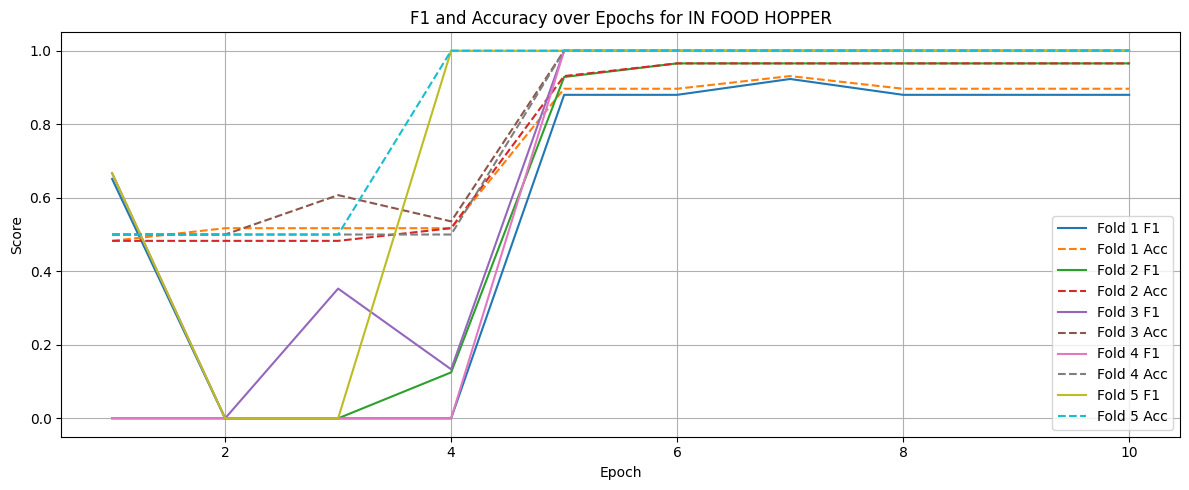


[IN FOOD HOPPER] Average F1: 0.9691, Accuracy: 0.9724


In [23]:
# Iterate through each label in the 'labels' list
print(f"Running cross-validation for label: {labels[0]}")
f1, acc = cross_validate_binary_model(df_labels_0, image_dir='train_frames', label_name=labels[0], epochs=10)
cv_results[labels[0]] = {'F1': f1, 'Accuracy': acc}

Running cross-validation for label: IN HOUSE (N)

Fold 1/5
Epoch 1: Loss: 43.9969, F1: 0.8442, Acc: 0.8195
Epoch 2: Loss: 36.7541, F1: 0.8760, Acc: 0.8872
Epoch 3: Loss: 29.3914, F1: 0.8760, Acc: 0.8872
Epoch 4: Loss: 28.6322, F1: 0.8760, Acc: 0.8872
Epoch 5: Loss: 27.0484, F1: 0.8760, Acc: 0.8872
Epoch 6: Loss: 23.8567, F1: 0.8833, Acc: 0.8947
Epoch 7: Loss: 23.7022, F1: 0.8833, Acc: 0.8947
Epoch 8: Loss: 22.9247, F1: 0.8833, Acc: 0.8947
Epoch 9: Loss: 21.5586, F1: 0.8833, Acc: 0.8947
Epoch 10: Loss: 20.5084, F1: 0.8833, Acc: 0.8947

Fold 2/5
Epoch 1: Loss: 41.0701, F1: 0.9106, Acc: 0.9173
Epoch 2: Loss: 32.5547, F1: 0.9106, Acc: 0.9173
Epoch 3: Loss: 30.5094, F1: 0.8550, Acc: 0.8571
Epoch 4: Loss: 25.9474, F1: 0.9106, Acc: 0.9173
Epoch 5: Loss: 24.9732, F1: 0.9106, Acc: 0.9173
Epoch 6: Loss: 22.9649, F1: 0.9106, Acc: 0.9173
Epoch 7: Loss: 24.5101, F1: 0.9106, Acc: 0.9173
Epoch 8: Loss: 24.9085, F1: 0.9106, Acc: 0.9173
Epoch 9: Loss: 22.4515, F1: 0.9106, Acc: 0.9173
Epoch 10: Loss: 22

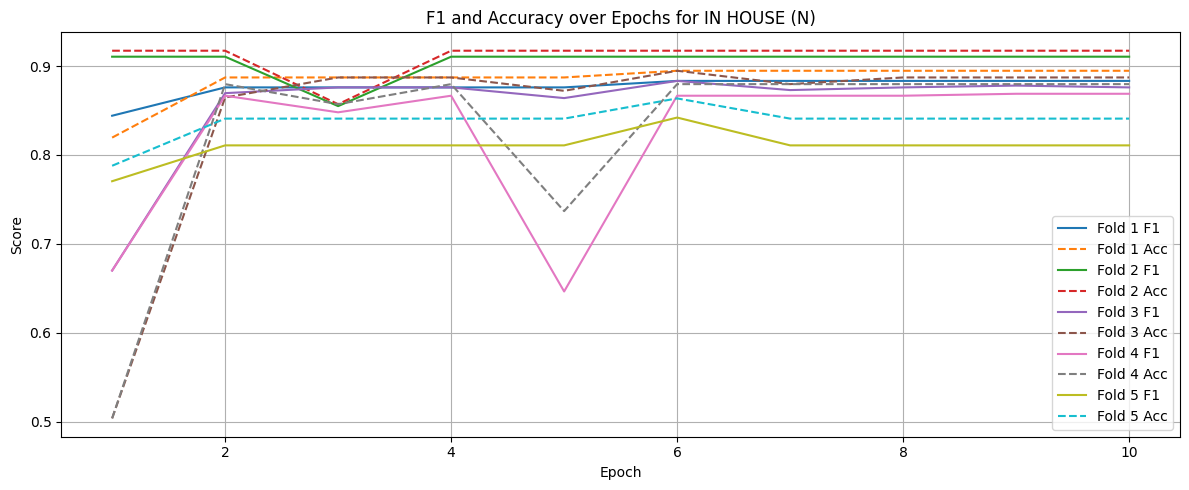


[IN HOUSE (N)] Average F1: 0.8699, Accuracy: 0.8840


In [24]:
# Iterate through each label in the 'labels' list
print(f"Running cross-validation for label: {labels[1]}")
f1, acc = cross_validate_binary_model(df_labels_1, image_dir='train_frames', label_name=labels[1], epochs=10)
cv_results[labels[1]] = {'F1': f1, 'Accuracy': acc}

In [25]:
# Iterate through each label in the 'labels' list
print(f"Running cross-validation for label: {labels[2]}")
f1, acc = cross_validate_binary_model(df_labels_2, image_dir='train_frames', label_name=labels[2], epochs=10)
cv_results[labels[2]] = {'F1': f1, 'Accuracy': acc}

Running cross-validation for label: IN HOUSE (S)

Fold 1/5
Epoch 1: Loss: 44.3254, F1: 0.9192, Acc: 0.9130
Epoch 2: Loss: 24.9161, F1: 0.9192, Acc: 0.9130
Epoch 3: Loss: 19.4248, F1: 0.9192, Acc: 0.9130


KeyboardInterrupt: 

In [ ]:
# Iterate through each label in the 'labels' list
print(f"Running cross-validation for label: {labels[2]}")
f1, acc = cross_validate_binary_model(df_labels_3, image_dir='train_frames', label_name=labels[3], epochs=10)
cv_results[labels[2]] = {'F1': f1, 'Accuracy': acc}

In [ ]:
# Iterate through each label in the 'labels' list
print(f"Running cross-validation for label: {labels[2]}")
f1, acc = cross_validate_binary_model(df_labels_4, image_dir='train_frames', label_name=labels[4], epochs=10)
cv_results[labels[2]] = {'F1': f1, 'Accuracy': acc}

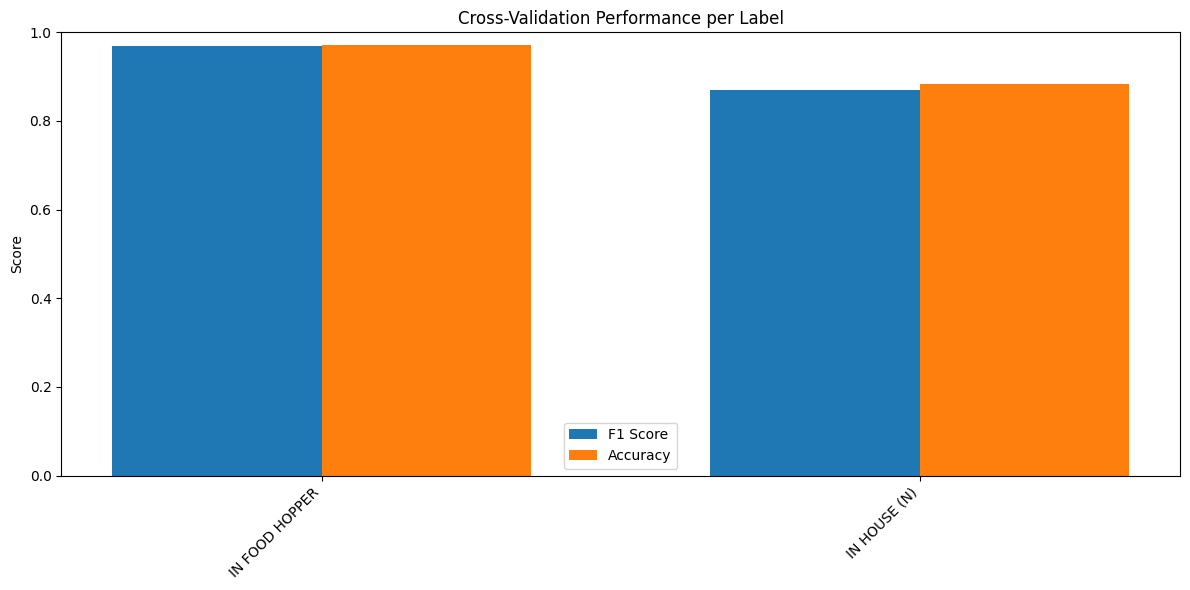

In [26]:
plot_cv_results(cv_results)

# Predict on Test Data

In [57]:
import datetime

upload_folder = 'test_frames'
zip_filename = 'test_frames.zip'
clear_annotations_folder(upload_folder)

# Ensure the destination folder exists
os.makedirs(upload_folder, exist_ok=True)

# Upload the zip file
print(f"Upload your zip file named {zip_filename}")
uploaded = files.upload()
if zip_filename not in uploaded:
    print(f"Error: '{zip_filename}' not uploaded.")

# Unzip frames into the upload folder
unzip_and_merge(zip_filename, upload_folder)
print(f"Frames unzipped to {upload_folder}")

Upload your zip file named test_frames.zip


Saving test_frames.zip to test_frames (1).zip
Error: 'test_frames.zip' not uploaded.
Frames unzipped to test_frames


In [70]:
epoch_num = 6

# Image transform (same as training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
])

# Dataset for prediction
class PredictionDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = sorted([
            fname for fname in os.listdir(image_dir)
            if os.path.isfile(os.path.join(image_dir, fname))
            and fname.lower().endswith(('.png', '.jpg', '.jpeg'))
            and not fname.startswith('._')
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[idx]

pred_dataset = PredictionDataset(upload_folder, transform=transform)
pred_loader = DataLoader(pred_dataset, batch_size=8, shuffle=False)

# Mapping labels to their balanced DataFrames
label_to_df = {
    labels[0]: df_labels_0,
    labels[1]: df_labels_1,
    labels[2]: df_labels_2,
    labels[3]: df_labels_3,
    labels[4]: df_labels_4,
}

# Train a model per label using its balanced dataset
trained_models = {}
for label in labels:
    print(f"Training model for label: {label}")
    df_balanced = label_to_df[label]
    model = train_binary_model(df_balanced, image_dir='train_frames', label_name=label, epochs=epoch_num)
    trained_models[label] = model

# Create predictions dict per frame
frame_predictions = {filename: [] for filename in pred_dataset.image_names}
total_frames = len(pred_dataset)


Training model for label: IN FOOD HOPPER
[IN FOOD HOPPER] Epoch 1/6: Loss: 8.6532
[IN FOOD HOPPER] Epoch 2/6: Loss: 7.0418
[IN FOOD HOPPER] Epoch 3/6: Loss: 4.2377
[IN FOOD HOPPER] Epoch 4/6: Loss: 4.8660
[IN FOOD HOPPER] Epoch 5/6: Loss: 5.3272
[IN FOOD HOPPER] Epoch 6/6: Loss: 2.9268
Training model for label: IN HOUSE (N)
[IN HOUSE (N)] Epoch 1/6: Loss: 44.4563
[IN HOUSE (N)] Epoch 2/6: Loss: 35.7180
[IN HOUSE (N)] Epoch 3/6: Loss: 28.3065
[IN HOUSE (N)] Epoch 4/6: Loss: 28.6743
[IN HOUSE (N)] Epoch 5/6: Loss: 26.0058
[IN HOUSE (N)] Epoch 6/6: Loss: 26.9619
Training model for label: IN HOUSE (S)
[IN HOUSE (S)] Epoch 1/6: Loss: 44.5448
[IN HOUSE (S)] Epoch 2/6: Loss: 26.4839
[IN HOUSE (S)] Epoch 3/6: Loss: 23.7591
[IN HOUSE (S)] Epoch 4/6: Loss: 21.3381
[IN HOUSE (S)] Epoch 5/6: Loss: 17.2040
[IN HOUSE (S)] Epoch 6/6: Loss: 16.4390
Training model for label: ON HOUSE (N)
[ON HOUSE (N)] Epoch 1/6: Loss: 41.5543
[ON HOUSE (N)] Epoch 2/6: Loss: 38.4516
[ON HOUSE (N)] Epoch 3/6: Loss: 32.4

In [72]:
# Create a directory to save the models if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

for label, model in trained_models.items():
    # Save each model to a separate file
    model_path = os.path.join("trained_models", f"{label}_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for label '{label}' saved to {model_path}")

print("All models saved successfully.")


Model for label 'IN FOOD HOPPER' saved to trained_models/IN FOOD HOPPER_model.pth
Model for label 'IN HOUSE (N)' saved to trained_models/IN HOUSE (N)_model.pth
Model for label 'IN HOUSE (S)' saved to trained_models/IN HOUSE (S)_model.pth
Model for label 'ON HOUSE (N)' saved to trained_models/ON HOUSE (N)_model.pth
Model for label 'ON HOUSE (S)' saved to trained_models/ON HOUSE (S)_model.pth
All models saved successfully.


In [74]:
pred_loader

In [77]:
# Set model to eval mode
for model in trained_models.values():
    model.eval()

# Dictionary to collect predictions
results = []

# Go through each batch of test images
with torch.no_grad():
    for images, filenames in pred_loader:
        batch_preds = {label: trained_models[label](images).cpu().numpy() for label in labels}
        for i, filename in enumerate(filenames):
            frame_result = {
                "image": filename,
                "labels": []
            }
            for label in labels:
                if batch_preds[label][i] >= 0.5:
                    frame_result["labels"].append(label)
            results.append(frame_result)

# Save results to a JSONL file
output_jsonl = 'predictions.jsonl'
with open(output_jsonl, 'w') as f:
    for item in results:
        f.write(json.dumps(item) + '\n')

print(f"Predictions saved to {output_jsonl}")

# ---- Load the JSONL and display stats ----

# Load the JSONL into a DataFrame
df_pred = pd.DataFrame()
with open(output_jsonl, 'r') as f:
    for line in f:
        data = json.loads(line)
        df_pred = pd.concat([df_pred, pd.DataFrame([data])], ignore_index=True)

# Set image name as index
df_pred.set_index('image', inplace=True)

# Create a multi-hot encoded DataFrame for the predicted labels
df_pred_labels = pd.DataFrame(index=df_pred.index)

for label in labels:
    df_pred_labels[label] = df_pred['labels'].apply(lambda x: int(label in x))

# View basic prediction stats
def get_stats(df):
    df_stats = pd.DataFrame(df.sum(axis=0)).rename(columns={0: 'total'}).sort_values(by="total", ascending=False)
    df_stats['percentage'] = 100 * round(df_stats['total'] / len(df), 3)
    return df_stats

# Show the prediction summary
prediction_stats = get_stats(df_pred_labels)
display(prediction_stats)

Predictions saved to predictions.jsonl


,total,percentage
IN HOUSE (N),158,40.7
ON HOUSE (S),158,40.7
ON HOUSE (N),158,40.7
IN FOOD HOPPER,2,0.5
IN HOUSE (S),0,0.0
